# Implementation of Neural Style Transfer with PyTorch

In [121]:
from __future__ import print_function
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
import copy
import torch.optim as optim

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [159]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

ldr = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])  


image = Image.open("/content/n2.jpg")
# fake batch dimension required to fit network's input dimensions
image = ldr(image).unsqueeze(0)
ref_style_img = image.to(device, torch.float)

image = Image.open("/content/c2.jfif")
# fake batch dimension required to fit network's input dimensions
image = ldr(image).unsqueeze(0)
target_img = image.to(device, torch.float)

print(ref_style_img.shape)
print(target_img.shape)

assert ref_style_img.size() == target_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


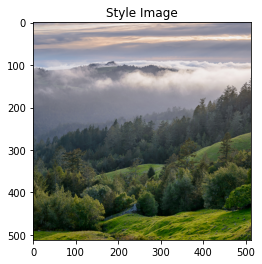

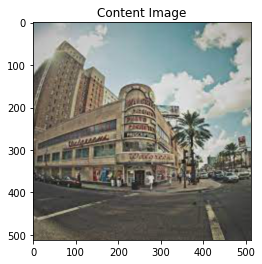

In [160]:
# visualizing the content and style images
reconvert = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = reconvert(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(ref_style_img, title='Style Image')
plt.figure()
imshow(target_img, title='Content Image')

In [161]:
class loss_cont(nn.Module):

    def __init__(self, target,):
        super(loss_cont, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [162]:
def GRM_MAT(input):
    a, b, c, d = input.size()  # a=batch size(=1)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product
    obtained= G.div(a * b * c * d)
    return obtained

In [163]:
class loss_ref(nn.Module):

    def __init__(self, target_feature):
        super(loss_ref, self).__init__()
        self.target = GRM_MAT(target_feature).detach()

    def forward(self, input):
        G = GRM_MAT(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [164]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()  #densenet161, efficientnet_b2 , googlenet, resnet18

In [165]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        ans=(img - self.mean) / self.std
        return ans

In [166]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, ref_style_img, target_img, content_layers=content_layers_default, style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses, style_losses = [],[]

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i =i+ 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(target_img).detach()
            model.add_module("content_loss_{}".format(i), loss_cont(target))
            content_losses.append(loss_cont(target))

        if name in style_layers:
            target_feature = model(ref_style_img).detach()
            model.add_module("style_loss_{}".format(i), loss_ref(target_feature))
            style_losses.append(loss_ref(target_feature))

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], loss_cont) or isinstance(model[i], loss_ref):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

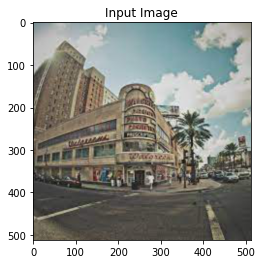

In [167]:
input_img = target_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [168]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [169]:
SL, CL = [],[]
def run_style_transfer(cnn, normalization_mean, normalization_std,target_img, ref_style_img, input_img, num_steps=310,style_weight=1500000, content_weight=1.9):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,normalization_mean, normalization_std, ref_style_img, target_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score,content_score = 0,0

            for sl in style_losses:
                style_score =style_score+ sl.loss
                SL.append(style_score.cpu().detach().numpy())
            for cl in content_losses:
                content_score =content_score+ cl.loss
                CL.append(content_score.cpu().detach().numpy())

            style_score =style_score* style_weight
            content_score =content_score* content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] =run[0]+ 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            total=style_score + content_score
            return total

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 43.706161 Content Loss: 14.560719

run [100]:
Style Loss : 15.914868 Content Loss: 13.175012

run [150]:
Style Loss : 7.232768 Content Loss: 11.874210

run [200]:
Style Loss : 3.046057 Content Loss: 10.881204

run [250]:
Style Loss : 1.642833 Content Loss: 9.858913

run [300]:
Style Loss : 1.274135 Content Loss: 9.127895

[array(5.206051e-06, dtype=float32), array(0.00010994, dtype=float32), array(0.00067531, dtype=float32), array(0.0010522, dtype=float32), array(0.00238569, dtype=float32), array(5.206027e-06, dtype=float32), array(0.00010994, dtype=float32), array(0.00067528, dtype=float32), array(0.00105211, dtype=float32), array(0.00238519, dtype=float32), array(5.136926e-06, dtype=float32), array(0.00010127, dtype=float32), array(0.0005299, dtype=float32), array(0.00074662, dtype=float32), array(0.00129989, dtype=float32), array(5.1392662e-06, dtype=float32), array(9.060655e-05, dtype=float32), array(0.00022622, dtype=float32), array(0.00033235, dtype=float32

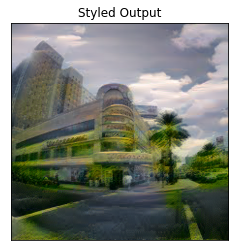

In [170]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,target_img, ref_style_img, input_img)

print(SL)
print(CL)
plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

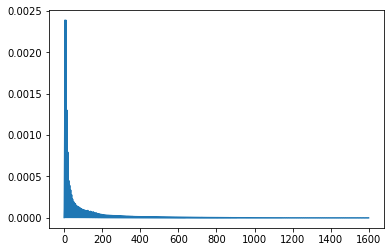

In [175]:
import matplotlib.pyplot as plt
plt.plot(range(0,1600), SL)
plt.show()

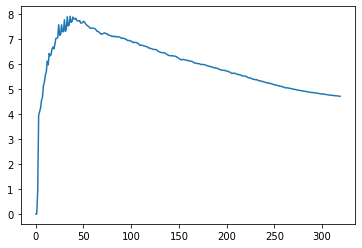

In [176]:
import matplotlib.pyplot as plt
plt.plot(range(0,320), CL)
plt.show()

In [174]:
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "styled1.jpg")